In [ ]:
import pandas as pd
import numpy as np 
import sqlite3
from matplotlib import pyplot as plt

**LOAD DATASET**


In [ ]:
data = pd.read_csv('./Train/final_train_data.csv',error_bad_lines=False)
data.shape

(300968, 3)

**Drop** **Duplicates**

In [ ]:
final = data.drop_duplicates(subset={"label","text"},keep='first',inplace=False)
final.shape

(299909, 3)

# **Dataset Cleaning**

In [ ]:
import re
def cleanhtml(sentence):
    cleanr1 = re.compile('/.*?')
    cleantext = re.sub(cleanr1,' ',sentence)
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

In [ ]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()

In [ ]:
stopwords = pd.read_csv('./stopword/Stopwords.csv')

In [ ]:
def to_encode(bangla_word):
    return bangla_word.encode('utf-8')


def to_decode(bangla_word):
    return bangla_word.decode('utf-8')
set_stop = set(stopwords['words'].map(to_encode))

In [ ]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    cleaned = re.sub(r'[A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z]', r'', cleaned1)
    cleaned1 = re.sub(r'[1|2|3|4|5|6|7|8|9|0]', r'', cleaned)
    return cleaned1

In [ ]:
def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word1 in cleanhtml(w).split():
                for cleaned_word in clean_punct(cleaned_word1).split():
                    if len(cleaned_word)>2:
                        if(to_encode(cleaned_word) not in set_stop):
                            s = stemmer.stem_word(cleaned_word)
                            if len(s)>2:
                                final_words.append(s)
                                filtered_sentence.append(s)
                        else:
                            continue
                    else:
                        continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

# **Getting clean train data and its shape**

In [ ]:
X_train = pre_process(final['text'].values)
y_train = final['label'].values

In [ ]:
data1 = pd.read_csv('./Test/final_test_data.csv')
data1.shape

(75243, 3)

# **Getting Clean test data & its shape**

In [ ]:
final1=data1.drop_duplicates(subset={"label","text"},keep='first',inplace=False)
final1.shape

(75150, 3)

In [ ]:
X_test = pre_process(final1['text'].values)
y_test = final1['label'].values

In [ ]:
labels=np.unique(y_train)

In [ ]:
labels

array(['eco', 'ent', 'int', 'sprt', 'state'], dtype=object)

# **SVM**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn . model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
svm = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10000, tol=None)),
              ])
Gmodel=svm.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = svm.predict(X_test)

accuracy = cross_val_score(Gmodel,X_train,y_train,cv=5,scoring='accuracy')
print("Cross val score:",accuracy)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('accuracy normalized %s' % accuracy_score(y_pred, y_test, normalize=False))
print(classification_report(y_test, y_pred,target_names=labels))

Cross val score: [0.85679515 0.85697614 0.85567577 0.85806936 0.85906734]
Accuracy of Model with Cross Validation is: 85.73167520206889
accuracy 0.8564870259481038
accuracy normalized 64365
              precision    recall  f1-score   support

         eco       0.93      0.23      0.37      3796
         ent       0.92      0.69      0.79      6194
         int       0.94      0.29      0.44      6439
        sprt       0.93      0.90      0.92     10176
       state       0.83      0.99      0.91     48545

    accuracy                           0.86     75150
   macro avg       0.91      0.62      0.68     75150
weighted avg       0.87      0.86      0.83     75150



**Training accuracy for svm**

In [ ]:
from sklearn.metrics import classification_report
y_pred = svm.predict(X_train)


print('accuracy %s' % accuracy_score(y_pred, y_train))
print('accuracy normalized %s' % accuracy_score(y_pred, y_train, normalize=False))
print(classification_report(y_train, y_pred,target_names=labels))

accuracy 0.8576301478115028
accuracy normalized 257211
              precision    recall  f1-score   support

         eco       0.93      0.22      0.36     15168
         ent       0.92      0.70      0.80     24454
         int       0.94      0.29      0.45     25748
        sprt       0.93      0.90      0.92     40683
       state       0.84      0.99      0.91    193856

    accuracy                           0.86    299909
   macro avg       0.91      0.62      0.69    299909
weighted avg       0.87      0.86      0.83    299909



# **Multinomial Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn . model_selection import cross_val_score

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=.01)),
              ])
Gmodel = nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)


print("Cross val score:",cross_val_score(Gmodel,X_train,y_train,cv=5,scoring='accuracy'))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('accuracy normalized %s' % accuracy_score(y_pred, y_test, normalize=False))
print(classification_report(y_test, y_pred,target_names=labels))

Cross val score: [0.90520806 0.90684027 0.90550656 0.90765255 0.90623385]
accuracy 0.907185628742515
accuracy normalized 68175
              precision    recall  f1-score   support

         eco       0.83      0.58      0.68      3796
         ent       0.90      0.81      0.85      6194
         int       0.88      0.67      0.76      6439
        sprt       0.97      0.91      0.94     10176
       state       0.90      0.98      0.94     48545

    accuracy                           0.91     75150
   macro avg       0.90      0.79      0.84     75150
weighted avg       0.91      0.91      0.90     75150



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test,labels)

array([[ 2216,     3,    32,     2,   427],
       [   25,  5025,   109,    68,   354],
       [   67,    65,  4307,    74,   355],
       [   25,   149,    89,  9273,    55],
       [ 1463,   952,  1902,   759, 47354]], dtype=int64)

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


Confusion matrix, without normalization
[[ 2216    25    67    25  1463]
 [    3  5025    65   149   952]
 [   32   109  4307    89  1902]
 [    2    68    74  9273   759]
 [  427   354   355    55 47354]]
Normalized confusion matrix
[[5.84e-01 6.59e-03 1.77e-02 6.59e-03 3.85e-01]
 [4.84e-04 8.11e-01 1.05e-02 2.41e-02 1.54e-01]
 [4.97e-03 1.69e-02 6.69e-01 1.38e-02 2.95e-01]
 [1.97e-04 6.68e-03 7.27e-03 9.11e-01 7.46e-02]
 [8.80e-03 7.29e-03 7.31e-03 1.13e-03 9.75e-01]]


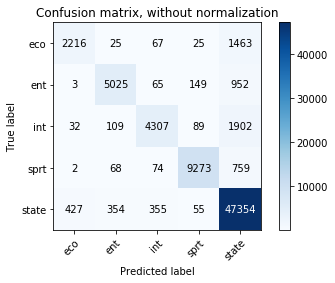

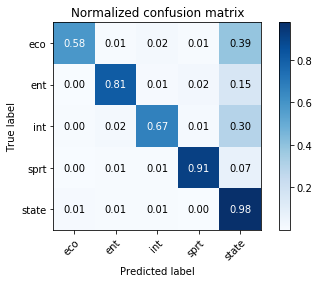

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **Random Forest**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn . model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
Rmodel = RandomForestClassifier ( n_estimators=100 )

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier ( n_estimators=100 )),
              ])
Rmodel=lr.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = lr.predict(X_test)


print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('accuracy normalized %s' % accuracy_score(y_pred, y_test, normalize=False))
print(classification_report(y_test, y_pred,target_names=labels))



Cross val score: [0.91 0.91 0.91 0.91 0.91]
Accuracy of Model with Cross Validation is: 90.62882572895357
accuracy 0.8646972721224219
accuracy normalized 64982
              precision    recall  f1-score   support

         eco       0.94      0.26      0.41      3796
         ent       0.97      0.69      0.80      6194
         int       0.96      0.35      0.51      6439
        sprt       0.95      0.90      0.92     10176
       state       0.84      1.00      0.91     48545

    accuracy                           0.86     75150
   macro avg       0.93      0.64      0.71     75150
weighted avg       0.88      0.86      0.84     75150



Confusion matrix, without normalization
[[ 1003     2    18    23  2750]
 [    0  4260    16   236  1682]
 [    3    58  2227   171  3980]
 [    1    39    11  9160   965]
 [   58    42    43    70 48332]]
Normalized confusion matrix
[[2.64e-01 5.27e-04 4.74e-03 6.06e-03 7.24e-01]
 [0.00e+00 6.88e-01 2.58e-03 3.81e-02 2.72e-01]
 [4.66e-04 9.01e-03 3.46e-01 2.66e-02 6.18e-01]
 [9.83e-05 3.83e-03 1.08e-03 9.00e-01 9.48e-02]
 [1.19e-03 8.65e-04 8.86e-04 1.44e-03 9.96e-01]]


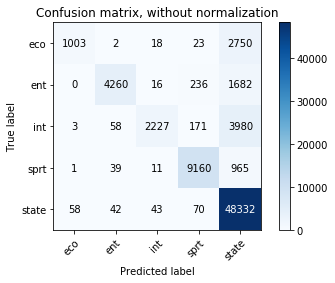

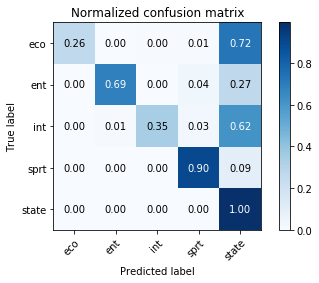

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

accuracy = cross_val_score(Rmodel,X_train,y_train,cv=5,scoring='accuracy')
print("Cross val score:",accuracy)

Cross val score: [0.86 0.86 0.86 0.86 0.86]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 86.00142078087248


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn . model_selection import cross_val_score

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression ( multi_class = 'ovr' , solver = 'lbfgs' )),
              ])
Gmodel=lr.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = lr.predict(X_test)

print("Cross val score:",cross_val_score(Gmodel,X_train,y_train,cv=5,scoring='accuracy'))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('accuracy normalized %s' % accuracy_score(y_pred, y_test, normalize=False))
print(classification_report(y_test, y_pred,target_names=labels))



In [ ]:
from sklearn.metrics import classification_report

accuracy = cross_val_score(Gmodel,X_train,y_train,cv=5,scoring='accuracy')
print("Cross val score:",accuracy)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

C:\Users\Nusrat Humaira\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Nusrat Humaira\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Nusrat Humaira\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Nusrat Humaira\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Nusrat Humaira\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

Cross val score: [0.94 0.94 0.94 0.94 0.94]
Accuracy of Model with Cross Validation is: 93.79945262308546


Confusion matrix, without normalization
[[ 2716    21    98    25   936]
 [    7  5456   104   137   490]
 [   45   121  5447    62   764]
 [    8    82    95  9737   254]
 [  531   316   352   111 47235]]
Normalized confusion matrix
[[7.15e-01 5.53e-03 2.58e-02 6.59e-03 2.47e-01]
 [1.13e-03 8.81e-01 1.68e-02 2.21e-02 7.91e-02]
 [6.99e-03 1.88e-02 8.46e-01 9.63e-03 1.19e-01]
 [7.86e-04 8.06e-03 9.34e-03 9.57e-01 2.50e-02]
 [1.09e-02 6.51e-03 7.25e-03 2.29e-03 9.73e-01]]


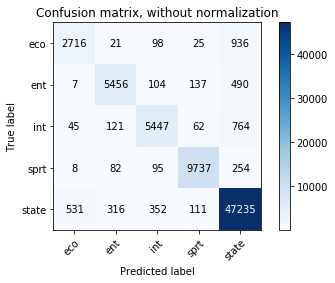

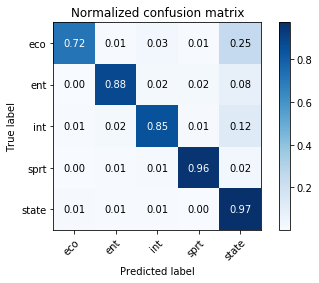

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
label=np.array(['economics', 'entertainment', 'international', 'sports', 'state'], dtype=object)

#**confusion matrix by adding full label** 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
svm = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10000, tol=None)),
              ])
Gmodel=svm.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = svm.predict(X_test)


Confusion matrix, without normalization
[[  867     1    19     0    48]
 [   17  4278   141    62   165]
 [   30    22  1841    13    50]
 [   64   265   259  9203   106]
 [ 2818  1628  4179   898 48176]]
Normalized confusion matrix
[[0.93 0.   0.02 0.   0.05]
 [0.   0.92 0.03 0.01 0.04]
 [0.02 0.01 0.94 0.01 0.03]
 [0.01 0.03 0.03 0.93 0.01]
 [0.05 0.03 0.07 0.02 0.83]]


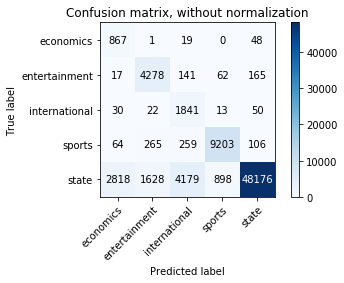

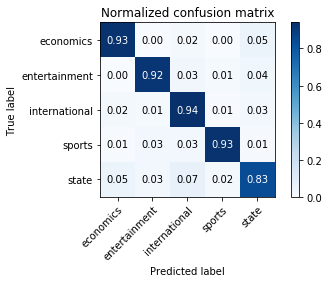

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix( y_pred,y_test, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix( y_pred,y_test, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from collections import Counter
Counter(x for sublist in X_train for x in sublist)

Counter({'চ': 734528,
         'া': 7639240,
         'ঁ': 130359,
         'দ': 1479977,
         'প': 2023785,
         'ু': 1386656,
         'র': 4491579,
         ' ': 11082608,
         'গ': 921456,
         'ত': 2285918,
         'ক': 2805767,
         'ল': 2321951,
         'স': 2564671,
         'ে': 2145259,
         'ম': 2330891,
         'ব': 2677350,
         'ি': 4162386,
         'ন': 3685677,
         '্': 5191358,
         'য': 1450470,
         'ী': 900237,
         'ৃ': 129939,
         'ষ': 597749,
         'শ': 1109486,
         'হ': 910361,
         'ণ': 334531,
         'অ': 469100,
         'ধ': 491989,
         'ঙ': 103279,
         'উ': 398702,
         'জ': 1141070,
         'ই': 448151,
         'ভ': 570232,
         'আ': 657293,
         'ঠ': 186929,
         'ট': 825567,
         'য়': 657639,
         'ছ': 343182,
         'থ': 433180,
         'ো': 788585,
         'ড়': 186071,
         'খ': 396999,
         'ৈ': 64574,
         'ও': 180356,
         'ড':